# Import

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch import optim
from sklearn.metrics import accuracy_score, f1_score

In [2]:
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the Data

In [3]:
# Pipline of transformation
transform = transforms.Compose(
  [transforms.ToTensor(),
  transforms.Normalize((0.1307,), (0.3081,))]
  )
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)


# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

## Visualize a Batch

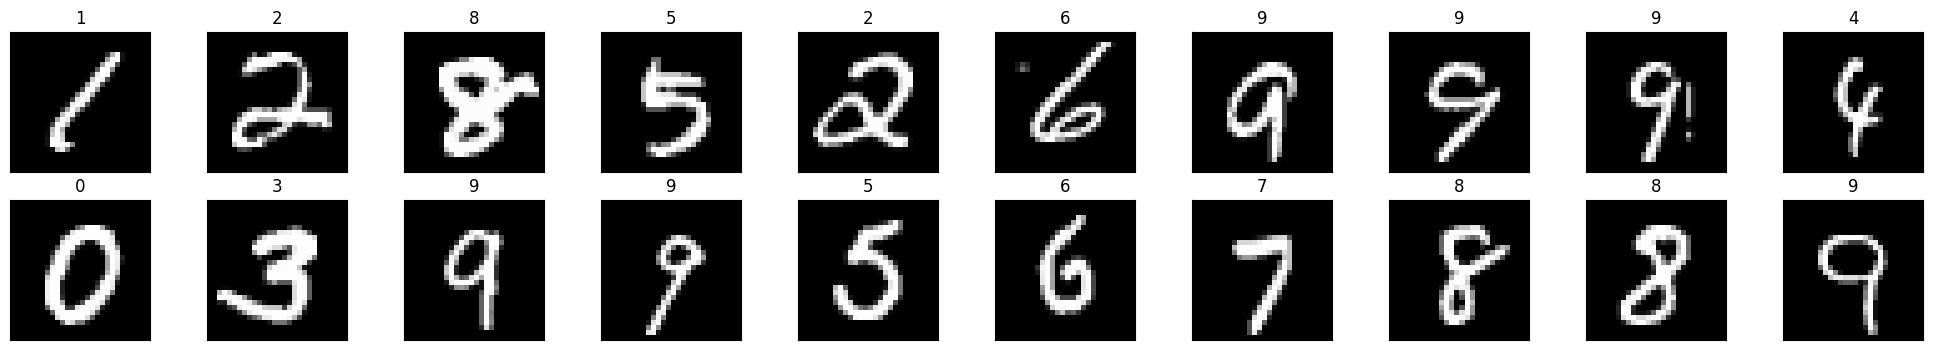

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2,10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

# Model

In [5]:
class DenseModel(nn.Module):
    def __init__(self):
        super(DenseModel, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.5)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.dropout1(F.relu(x))
        x = self.fc2(x)
        x = self.dropout1(F.relu(x))
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        
        return x

In [23]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

## Initialize

In [26]:
# Train the network here
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss() # nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

## Train

The steps for training/learning from a batch of data are described in the comments below:

* Clear the gradients of all optimized variables
* Forward pass: compute predicted outputs by passing inputs to the model
* Use the logits to calculate the loss
* Backward pass: compute gradient of the loss with respect to model parameters
* Perform a single optimization step (parameter update)



### Utils

In [8]:
def test(model, device, test_loader):
    model.eval()
    targets, labels = [], []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            
            targets.extend(target.detach().cpu().numpy())
            labels.extend(pred.detach().cpu().numpy())
            
    acc, f1 = accuracy_score(targets, labels), f1_score(targets, labels, average='macro')
    return acc, f1

In [9]:
def validation(model, device, val_loader, criterion):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()  # sum up batch loss
            
    return val_loss

In [10]:
def train(model, device, train_loader, optimizer, epoch, criterion):
    model.train()
    preds, labels = [], []
    train_loss = 0
    
    for _, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        preds.extend(output.argmax(dim=1).detach().cpu().numpy())
        labels.extend(target.detach().cpu().numpy())
        train_loss += loss.item()
        
    acc, f1 = accuracy_score(labels, preds), f1_score(labels, preds, average='macro')
    print(f"Epoch: {epoch}, Training loss: {train_loss:.3f}, Accuracy: {acc:.3f}, F1: {f1:.3f}")
    
    return train_loss

### Train

In [25]:
epochs = 10
model.to(device)
for e in range(epochs):
    train(model, device, trainloader, optimizer, e, criterion)
    val_loss = validation(model, device, testloader, criterion)
    print(f"Epoch: {e}, Validation loss: {val_loss:.3f}")
 
print('Testing')   
acc, f1 = test(model, device, testloader)
print(f"Test accuracy: {acc:.3f}, F1: {f1:.3f}")

Epoch: 0, Training loss: 524.709, Accuracy: 0.826, F1: 0.823
Epoch: 0, Validation loss: 37.711
Epoch: 1, Training loss: 360.096, Accuracy: 0.883, F1: 0.881
Epoch: 1, Validation loss: 23.677
Epoch: 2, Training loss: 274.671, Accuracy: 0.910, F1: 0.909
Epoch: 2, Validation loss: 18.441
Epoch: 3, Training loss: 224.223, Accuracy: 0.927, F1: 0.926
Epoch: 3, Validation loss: 15.225
Epoch: 4, Training loss: 211.732, Accuracy: 0.933, F1: 0.932
Epoch: 4, Validation loss: 14.856
Epoch: 5, Training loss: 206.249, Accuracy: 0.934, F1: 0.934
Epoch: 5, Validation loss: 13.330
Epoch: 6, Training loss: 199.847, Accuracy: 0.936, F1: 0.935
Epoch: 6, Validation loss: 14.202
Epoch: 7, Training loss: 196.381, Accuracy: 0.938, F1: 0.938
Epoch: 7, Validation loss: 14.208
Epoch: 8, Training loss: 201.655, Accuracy: 0.936, F1: 0.935
Epoch: 8, Validation loss: 12.687
Epoch: 9, Training loss: 186.881, Accuracy: 0.940, F1: 0.940
Epoch: 9, Validation loss: 15.375
Testing
Test accuracy: 0.970, F1: 0.969


# Visualize prediction

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.transpose((1, 2, 0))

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    # ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    # ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.imshow(img.transpose((1, 2, 0)))
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

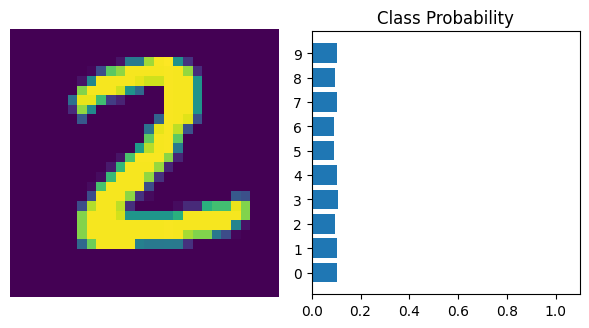

In [13]:
images, labels = next(iter(testloader))

images = images.to(device)
# Turn off gradients to speed up this part
with torch.no_grad():
    # exp because the last layer is log softmax
    output = torch.exp(model.forward(images))

images = images.detach().cpu().numpy()
output = output.detach().cpu().numpy()
view_classify(images[0], output[0])